In [1]:
import tensorflow as tf
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split

#### Download dataset

In [2]:
!pip install --upgrade gdown
!gdown --fuzzy 1B6inr_JHXRTidFsSMqOGhJWJr_09hXdF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1B6inr_JHXRTidFsSMqOGhJWJr_09hXdF
To: /content/where_am_i.tar
100% 89.9M/89.9M [00:00<00:00, 208MB/s]


In [3]:
!tar xf where_am_i.tar

#### Hyperparameters

In [4]:
IMG_SIZE = 224
BS = 64

In [5]:
with open("mapping.txt") as f:
    lines = f.readlines()
lines = [l.strip().replace(" ", "") for l in lines]
CLASS_MAP = {pair.split(",")[0]: int(pair.split(",")[1]) for pair in lines}

NUM_CLASS = len(CLASS_MAP)
CLASS_MAP, NUM_CLASS

({'CALsuburb': 9,
  'PARoffice': 7,
  'bedroom': 12,
  'coast': 10,
  'forest': 4,
  'highway': 14,
  'industrial': 2,
  'insidecity': 3,
  'kitchen': 0,
  'livingroom': 5,
  'mountain': 8,
  'opencountry': 6,
  'store': 11,
  'street': 1,
  'tallbuilding': 13},
 15)

#### Build Dataset

In [6]:
paths = glob("train/*/*.jpg")
train_paths, val_paths = train_test_split(paths, 
                                          test_size=0.2, 
                                          random_state=5566)

len(train_paths), len(val_paths)

(2152, 539)

((293, 220, 3), 'train/store/image_0159.jpg')

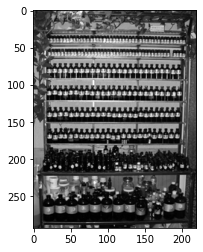

In [7]:
path = np.random.choice(train_paths)
img = np.array(Image.open(path).convert("RGB"))
plt.imshow(img)
img.shape, path

In [8]:
def paths2labels(paths):
    return [CLASS_MAP[p.split(os.sep)[-2]] for p in paths]

In [9]:
train_paths[:10], paths2labels(train_paths)[:10]

(['train/tallbuilding/image_0110.jpg',
  'train/PARoffice/image_0178.jpg',
  'train/insidecity/image_0151.jpg',
  'train/store/image_0270.jpg',
  'train/opencountry/image_0151.jpg',
  'train/livingroom/image_0034.jpg',
  'train/bedroom/image_0046.jpg',
  'train/opencountry/image_0003.jpg',
  'train/street/image_0150.jpg',
  'train/opencountry/image_0049.jpg'],
 [13, 7, 3, 11, 6, 5, 12, 6, 1, 6])

In [10]:
def load_and_resize_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

def build_ds(paths):
    labels = paths2labels(paths)
    image_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_ds = image_ds.map(lambda path, label: (load_and_resize_image(path), label))
    return image_ds

In [11]:

train_ds = build_ds(train_paths).shuffle(buffer_size=len(train_paths)).batch(BS)
val_ds = build_ds(val_paths).batch(BS)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


#### Build Model

In [12]:
class WAIModel(tf.keras.models.Model):
    def __init__(self, encoder, preprocess, freeze):
        super().__init__()
        self.preprocess = preprocess
        self.data_aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
        ])
        self.encoder = encoder
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(NUM_CLASS),
            tf.keras.layers.Softmax(),
        ])
        if freeze:
            for l in self.encoder.layers:
                l.trainable = False
    def call(self, inputs, training=None):
        x = self.preprocess(inputs)
        if training:
            x = self.data_aug(x)
            
        x = self.encoder(x, training)
        x = self.classifier(x, training)
        return x

In [13]:
preprocess = tf.keras.applications.efficientnet.preprocess_input
encoder = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, 
                                                            weights='imagenet')

model = WAIModel(encoder, 
                 preprocess,
                 freeze=True)

16705208/16705208 [==============================] - 0s 0us/step


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

#### Training

In [15]:
model.fit(train_ds, 
          epochs=20, 
          validation_data=val_ds,
          callbacks=[
              tf.keras.callbacks.ModelCheckpoint("best.h5",
                                                 save_best_only=True,
                                                 save_weights_only=True)
          ])

Epoch 1/20


34/34 [==============================] - 46s 446ms/step - loss: 1.7450 - sparse_categorical_accuracy: 0.5297 - val_loss: 0.9961 - val_sparse_categorical_accuracy: 0.7922
Epoch 2/20
34/34 [==============================] - 14s 349ms/step - loss: 0.8124 - sparse_categorical_accuracy: 0.8141 - val_loss: 0.6023 - val_sparse_categorical_accuracy: 0.8609
Epoch 3/20
34/34 [==============================] - 14s 355ms/step - loss: 0.5559 - sparse_categorical_accuracy: 0.8704 - val_loss: 0.4731 - val_sparse_categorical_accuracy: 0.8683
Epoch 4/20
34/34 [==============================] - 14s 344ms/step - loss: 0.4508 - sparse_categorical_accuracy: 0.8871 - val_loss: 0.4106 - val_sparse_categorical_accuracy: 0.8813
Epoch 5/20
34/34 [==============================] - 14s 343ms/step - loss: 0.3897 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.3737 - val_sparse_categorical_accuracy: 0.8850
Epoch 6/20
34/34 [==============================] - 14s 347ms/step - loss: 0.3347 - sparse_categorical_acc

#### Test submission

In [16]:
import pandas as pd

In [17]:
model.load_weights("best.h5")

In [18]:
df = pd.read_csv("sample_submission.csv")

In [19]:
df.head(), len(df)

(                     id  class
 0  12VJYE4AE85K3QZZIDGW      0
 1  4XLB86I30GZZZEVZBM2O      0
 2  TRS0Y4KQO74ET6A7POW8      0
 3  0R4BF4JPJL4QG25GNJRH      0
 4  YHQSSCEBEBB99DLIRTK8      0, 1794)

In [20]:
test_paths = [os.path.join(f"test/{name}.jpg") for name in df["id"].tolist()]
test_ds = tf.data.Dataset.from_tensor_slices((test_paths))
test_ds = test_ds.map(lambda path: load_and_resize_image(path)).batch(BS)

In [21]:
prediction = model.predict(test_ds)

29/29 [==============================] - 5s 115ms/step


In [22]:
prediction = np.argmax(prediction, axis=-1)

In [23]:
df["class"] = prediction

In [24]:
df.to_csv("submission.csv", index=None)

Public  Private

0.92264 0.90529